# 第二次作业(修改版）

In [3]:
%matplotlib inline

## （1）解决了跨年月份计算的问题
## （2）解决了之前图1中数据显示不准确的问题

In [29]:
# -*- coding: utf-8 -*-

'''
Created on 2016年4月24日
@author: todoit
'''
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#设置美化格式
plt.style.use('ggplot')  

#星期字典
week_dict = {1:'星期一', 2:'星期二', 3:'星期三', 4:'星期四', 5:'星期五', 6:'星期六', 7:'星期日'}

#将文件读到dataframe中
def readOrders(file_name): 
    data = pd.read_csv(file_name, encoding='gbk')
    #修改列名为英文
    data = data.rename(columns={'订单ID': 'id', '金额': 'money','方式': 'channel','时间':'time'})
    
    #从字符串得到日期类型
    #时间格式(包括日期和时间)
    time_str = '%m/%d/%Y %H:%M'
    data['datetime'] = data.apply(lambda row: datetime.strptime(row['time'], time_str), axis=1)
    
    #时间格式,只有时间
    data['date'] = data.apply(lambda row: row['datetime'].date(), axis=1)
    
    #月份，这个有问题，查了很久解决不了，目前只在2015年能用，不知道如何在2016年将年份区别开
    data['month'] = data.apply(lambda row: row['datetime'].month, axis=1)
    
    #增加了老师提供的方法，将年和月作为index
    data['year-month'] = data.apply(lambda row: row['datetime'].isoformat()[0:7], axis=1)
    #print(data['year-month'])
    
    #year-month排序后的序号，这样才能在bar中画图
    #得到data['year-month']中的set
    sorted_year_month_list = sorted(set(data['year-month'].tolist()), reverse=False)
    #print(sorted_year_month_list)
    #年-月组成的字符串排序后放入字典，以便后面使用
    year_month_No_dict = {}
    num = 1
    for year_month in sorted_year_month_list:
        year_month_No_dict[year_month] = num
        num += 1
    data['year-month-No'] = data.apply(lambda row: year_month_No_dict[row['year-month']], axis=1)
   
    #增加星期列，数字
    data['week_id'] = data.apply(lambda row: row['datetime'].weekday()+1, axis=1)
    #增加星期列，名称
    data['week_name'] = data.apply(lambda row: week_dict[row['week_id']], axis=1)
    
    #小时，几点
    data['hour'] = data.apply(lambda row: row['datetime'].hour, axis=1)
    
    #返回结果按照时间排序
    return data


#用户分析
def userAnalysis(data):

    fig = plt.figure(figsize=(10,30))#figsize=(10,6)

    #行, 列, 序号
    ax0 = fig.add_subplot(411) 
    ax1 = fig.add_subplot(412)
    ax2 = fig.add_subplot(413)
    ax3 = fig.add_subplot(414)
    
    #用户增长趋势分析，按天
    N = 1 #设置分布宽度
    date_list = data['date'].tolist()
    #之前bins参数计算错误， 现在用最大日期减去最小日期之间的天数+1作为bins的参数
    ax0.hist(date_list, bins=int((max(date_list) - min(date_list)).days)+1, normed=0, histtype='bar', facecolor='g', alpha=1)
    ax0.set_title('图1 用户数量增长情况-按天')

    
    #用户在星期上的分布
    week_count = data['week_id'].value_counts()

    ax1.bar(week_count.index.values.tolist(),week_count.values.tolist(),align="center")
    ax1.set_xticks(list(range(1,8)))
    ax1.set_xticklabels(week_dict.values())
    ax1.set_title('图2 用户在星期上的分布')
    
    
    
    #用户在月份上的分布
    month_count = data['year-month-No'].value_counts()
    #print(month_count)
    ax2.bar(month_count.index.values.tolist(),month_count.values.tolist(),align="center")
    ax2.set_xticks(range(min(data['year-month-No']), max(data['year-month-No'])+1))
    ax2.set_xticklabels(sorted(set(data['year-month'].tolist()), reverse=False))
   
    ax2.set_title('图3 用户在月份上的分布')
    
    #用户在每天时间段上的分布
    hour_count = data['hour'].value_counts()
    ax3.bar(hour_count.index.values.tolist(),hour_count.values.tolist())
    ax3.set_xticks(list(range(0,24)))
    
    data['year-month']
    ax3.set_title('图4 用户在一天内时间段的分布')
    
    
    fig.subplots_adjust(hspace=0.3)
    plt.show()


#价格收入等分析
def moneyAnalysis(data):
    import matplotlib.cm as cm
    import itertools
    
    fig = plt.figure(figsize=(9,20))#figsize=(10,6)

    #行, 列, 序号
    ax0 = fig.add_subplot(211) 
    ax1 = fig.add_subplot(212)
 
    
    #不同支付方式在不同时间的价格变化
    channels = set(data['channel'].tolist())
    #生成颜色列表
    colors =   iter(cm.rainbow(np.linspace(0, 1, len(channels))))
    for channel in channels:
        date_list = data[data['channel']==channel]['datetime'].tolist()
        money_list = data[data['channel']==channel]['money'].tolist()
        ax0.scatter(date_list,money_list,label=channel,s=5,color=next(colors))
    ax0.legend()
    ax0.set_title('图5 不同支付方式在不同时间的交易金额变化')
    ax0.set_ylabel(u'金额  单位：元')
    ax0.set_xlabel(u'时间')
    
   
    
    #收入在月份上的变化
    money_month = data.groupby('year-month-No').sum()['money']
    #将money除以1000
    monty_month_value = [x/10  for x in money_month.values.tolist()]
    ax1.bar(money_month.index.values.tolist(),monty_month_value,facecolor='#9999ff',align="center")
    
    #用户在月份上的分布
    month_count = data['year-month-No'].value_counts()
    #将数据变为负数
    neg_month_count = [-x for x in month_count.values.tolist()]
    ax1.bar(month_count.index.values.tolist(),neg_month_count, facecolor='#ff9999',align="center")
    ax1.set_xticks(range(min(data['year-month-No']), max(data['year-month-No'])+1))
    ax1.set_xticklabels(sorted(set(data['year-month'].tolist()), reverse=False))
    
   
    ax1.set_title('图6 每月收入 (上）以及用户在月份上的分布（下）')
    ax1.set_ylabel(u'收入 单位： 十元； 用户单位：个')
    ax1.set_xlabel(u'月份')
    
    
    fig.subplots_adjust(hspace=0.3)
    plt.show()


## 1 用户分析

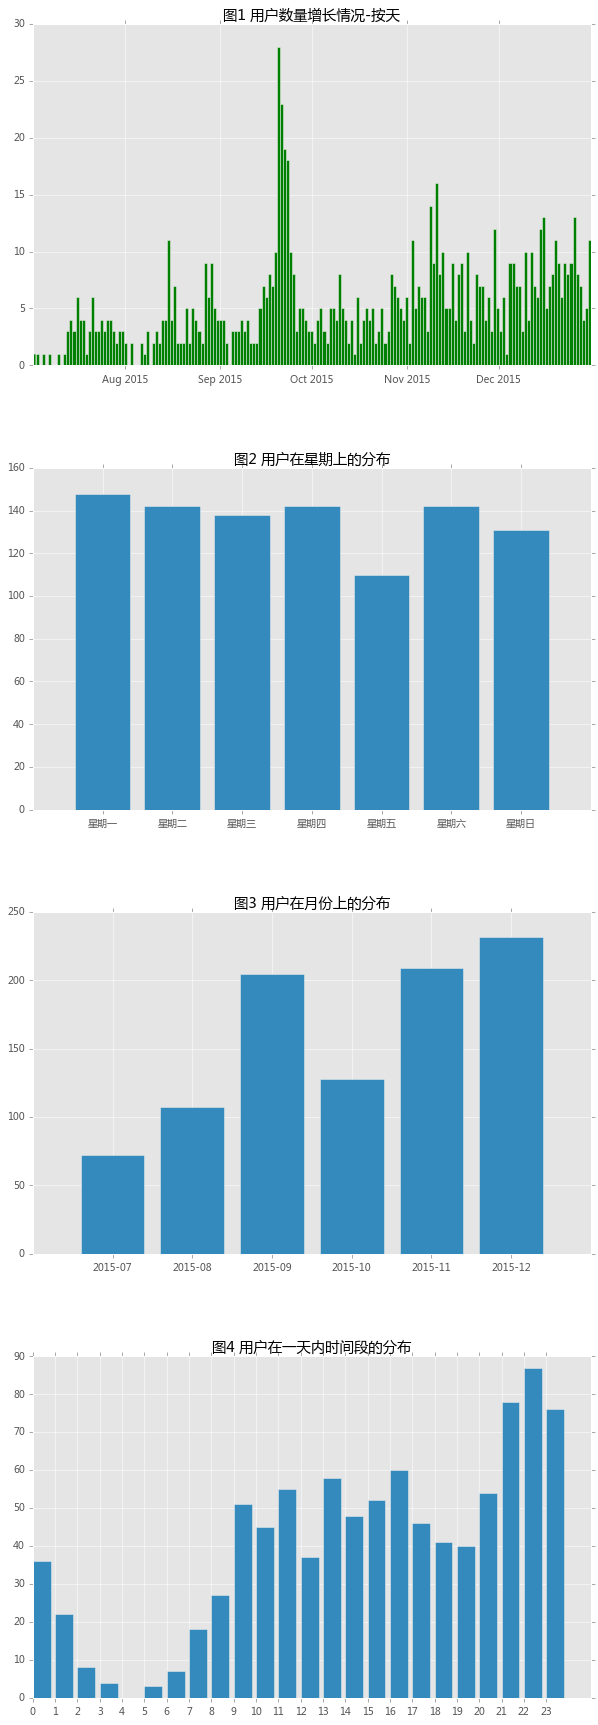

In [27]:
    data = readOrders('OutOrder.csv')
    #用户分析
    userAnalysis(data)

***
### 谈一些观察到的现象，有的原因无法说明
- 图1: 9月中下旬某几天用户增加很快，可能是网易有活动 ，例如http://science.china.com.cn/2015-09/25/content_8265445.htm
- 图2：周五明显比其他时间少
- 图3：10月份用户量相对较少，可能和9月份用户量太多有关
- 图4：很多程序员喜欢喜欢晚上学习？

## 2 交易分析

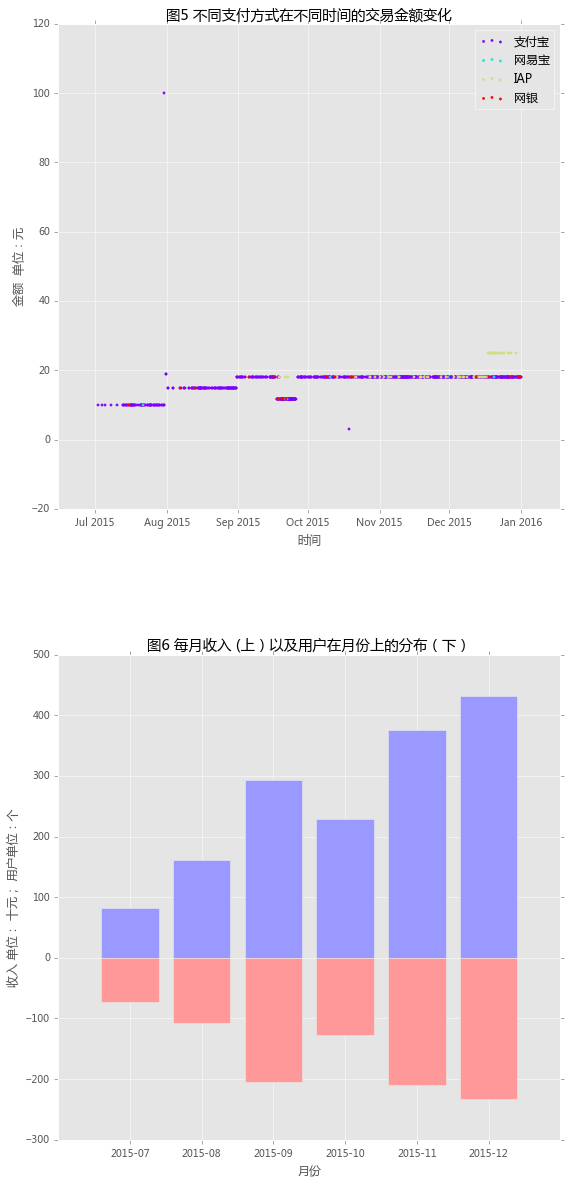

In [28]:
    moneyAnalysis(data)

***
### 总结

- 图5 支付宝用户量大，这是众所周知，但是还有一个重要发现是IAP用户都很有钱。还有一些异常点也值得注意。
- 图6 由于收入数据较大，将其除以10和用户比较，看来还是和用户很相关的。